In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['lyft-udacity-challenge']


In [23]:
image_path = '/kaggle/input/lyft-udacity-challenge/dataa/dataA/CameraRGB/'
mask_path = '/kaggle/input/lyft-udacity-challenge/dataa/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

/tmp/ipykernel_670/4026463561.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_670/4026463561.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

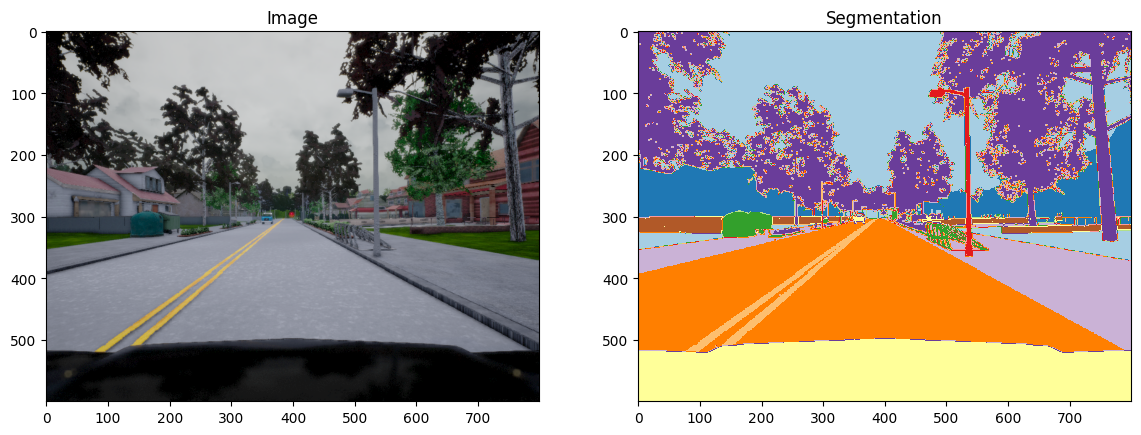

In [24]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

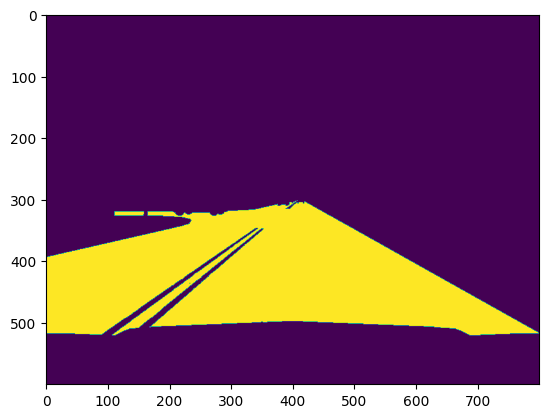

In [39]:
road = np.zeros((600, 800))
road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
plt.imshow(road)

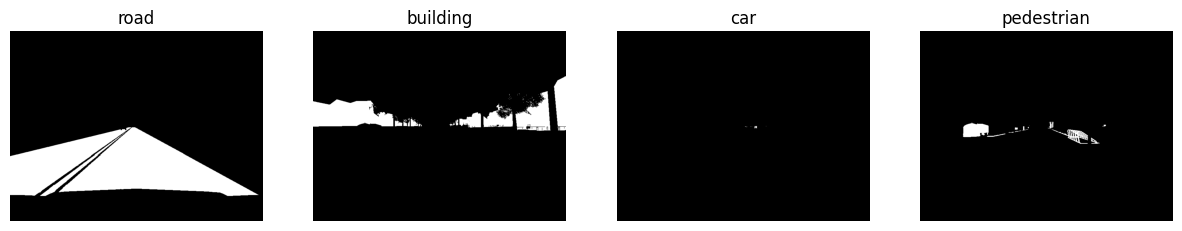

In [26]:
# Define the mask dimensions (assuming 600x800 for this example)
height, width = 600, 800

# Labels you want to display (modify based on your dataset's label map)
labels = {
    "road": 7,
    "building": 1,  # Replace with actual class label for building
    "car": 2,       # Replace with actual class label for car
    "pedestrian": 3 # Replace with actual class label for pedestrian
}

# Plot each label as a separate binary mask
fig, axes = plt.subplots(1, len(labels), figsize=(15, 5))
for i, (label_name, label_id) in enumerate(labels.items()):
    binary_mask = np.zeros((height, width))
    binary_mask[np.where(mask == label_id)[0], np.where(mask == label_id)[1]] = 1
    axes[i].imshow(binary_mask, cmap='gray')
    axes[i].set_title(label_name)
    axes[i].axis('off')

plt.show()


In [27]:
from tqdm import tqdm

In [28]:
height, width = 600, 800
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask_road = np.zeros((600, 800, 1), dtype=np.int8)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = img
    masks[n] = mask_road

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_670/1638083378.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[n])
/tmp/ipykernel_670/1638083378.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[n])
100%|██████████| 1000/1000 [00:39<00:00, 25.50it/s]


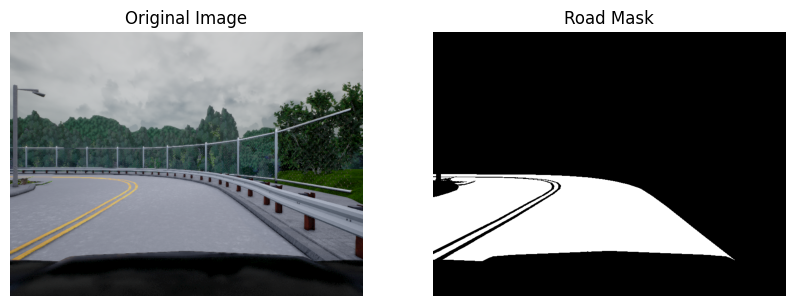

In [40]:
# Assuming 'images' and 'masks' arrays are already populated as in your code

# Let's visualize the first image and its corresponding mask
index = 0  # Change this index to visualize different images in the dataset

# Plotting the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[index])  # Display the image
plt.title("Original Image")
plt.axis('off')

# Plotting the mask image (road mask)
plt.subplot(1, 2, 2)
plt.imshow(masks[index].squeeze(), cmap='gray')  # Display the mask (squeezing to remove the extra dimension)
plt.title("Road Mask")
plt.axis('off')

plt.show()

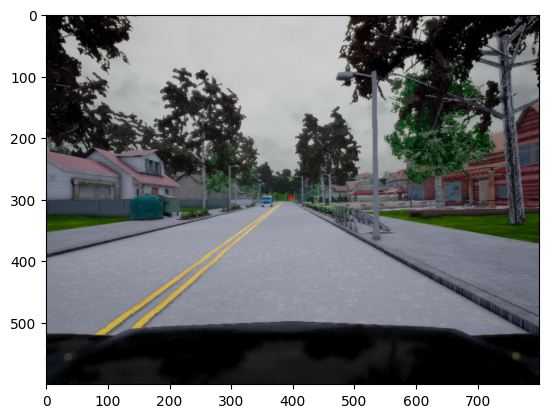

In [29]:
plt.imshow(images[1].reshape(600, 800, 3))

In [30]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [31]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [32]:
train_images.shape, val_images.shape, test_images.shape

((800, 600, 800, 3), (100, 600, 800, 3), (100, 600, 800, 3))

## Build U-Net with subtle changes¶


In [33]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [34]:
# Build U-Net model
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 600, 800,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 600, 800,  │        224 │ img[0][0]         │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 600, 800,  │        584 │ conv2d_15[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 300, 400,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 300, 400,  │      1,168 │ max_pooling2d_3[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 300, 400,  │      2,320 │ conv2d_17[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 150, 200,  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 150, 200,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 150, 200,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 75, 100,   │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 75, 100,   │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 75, 100,   │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 150, 200,  │     16,448 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 150, 200,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 96)               │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 150, 200,  │     27,680 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 150, 200,  │      9,248 │ conv2d_23[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 300, 400,  │      4,128 │ conv2d_24[0][0] 

 Total params: 143,729 (561.44 KB)

 Trainable params: 143,729 (561.44 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:

callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.keras', verbose=1, save_best_only=True)
]

results = model.fit(train_images, train_masks, batch_size=16, epochs=5, callbacks=callbacks,
                    validation_data=(val_images, val_masks))


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 6.5977
Epoch 1: val_loss improved from inf to 0.42714, saving model to model-sdc-seg-v2.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - loss: 6.5119 - val_loss: 0.4271 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.4050
Epoch 2: val_loss improved from 0.42714 to 0.37049, saving model to model-sdc-seg-v2.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - loss: 0.4047 - val_loss: 0.3705 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.3599
Epoch 3: val_loss improved from 0.37049 to 0.32804, saving model to model-sdc-seg-v2.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - loss: 0.3597 - val_loss: 0.3280 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.3340
Epoch 4: val_loss improved from 0.32804 to 0.31063, saving model to model-sdc-seg-v2.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - loss: 0.3339 - val_loss: 0.3106 

In [36]:
model.save('final-road-seg-model-v2.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


Text(0.5, 1.0, 'Ground truth')

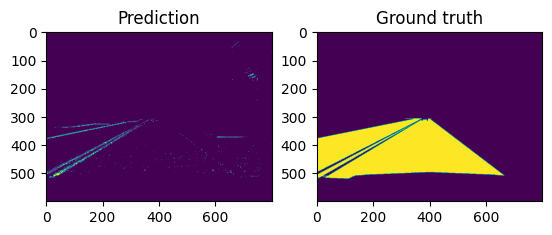

In [37]:
NUMBER = 0
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))
ax[1].set_title('Ground truth')

In [38]:
print("Prediction shape:", my_preds.shape)

Prediction shape: (480000,)
